# CelebVox2 Classifier

### Importing Packages

Importing the NumPy, Pandas and Matplotlib, PyTorch Scikit-Image etc. packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import torch
from skimage.transform import resize
from skimage.io import imread


## This line makes matplotlib plot the figures inside the notebook
%matplotlib inline

## Set some default values of the the matplotlib plots
plt.rcParams['figure.figsize'] = (8.0, 8.0)  # Set default plot's sizes
plt.rcParams['axes.grid'] = True  # Show grid by default in figures

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Interview/Corsound/jpeg/

id00061  id00081  id00419  id00812


## Loading Dataset

In [3]:
from os.path import split
import glob
path = '/content/drive/MyDrive/Interview/Corsound/jpeg/'
path_img = list(glob.glob(path+'/*/*/*.jpeg'))

labels = list(map(lambda x:split(split(x)[0])[-2], path_img))
labels = [label.split('/')[-1] for label in labels]
file_path = pd.Series(path_img, name='File_Path').astype(str)

labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels
0,/content/drive/MyDrive/Interview/Corsound/jpeg...,id00061
1,/content/drive/MyDrive/Interview/Corsound/jpeg...,id00419
2,/content/drive/MyDrive/Interview/Corsound/jpeg...,id00081
3,/content/drive/MyDrive/Interview/Corsound/jpeg...,id00061
4,/content/drive/MyDrive/Interview/Corsound/jpeg...,id00419


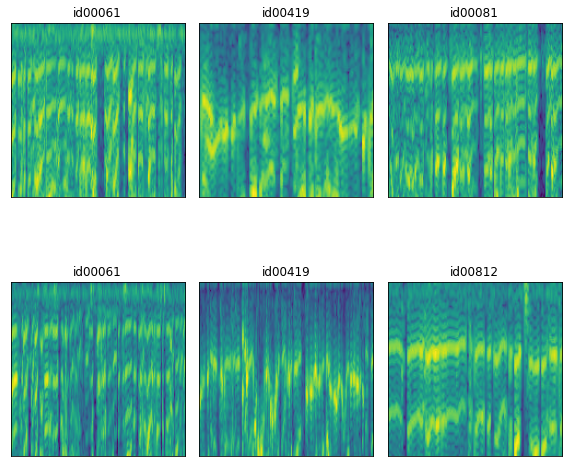

In [4]:
x = np.array([imread(file_path) for file_path in data.File_Path])
y = pd.factorize(data.Labels)[0]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(x[i])
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

In [5]:
data.Labels.value_counts()

id00419    430
id00812    298
id00081    273
id00061    266
Name: Labels, dtype: int64

## Train-Validation-Test split

In [6]:
n_samples = x.shape[0]  # The total number of samples in the dataset

## Generate a random generator with a fixed seed
rand_gen = np.random.RandomState(0)

## Generating a shuffled vector of indices
indices = np.arange(n_samples)
rand_gen.shuffle(indices)

## Split the indices into 60% train / 20% validation / 20% test
train_indices = indices[:int(0.6 * n_samples)]
val_indices = indices[int(0.6 * n_samples):int((0.6 + 0.2) * n_samples)]
test_indices = indices[int((0.6 + 0.2) * n_samples):]


## Extract the sub datasets from the full dataset using the calculated indices
x_train = x[train_indices]
y_train = y[train_indices]
x_val = x[val_indices]
y_val = y[val_indices]
x_test = x[test_indices]
y_test = y[test_indices]

## Mini-Batch Gradient Decent

In order to run over the dataset using mini batches PyTorch offers the class of [**torch.utils.data.DataLoader**](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) which receives a PyTorch dataset and generates a series of batches running over the dataset.

To generate a PyTorch dataset from a tensor of x and a tensor of y we will use the following command:

```python
torch.utils.data.TensorDataset(x, y)
```

We will convert x_train into a float tensor and y_train into a long integer tensor.

In [7]:
batch_size = 64
train_set = torch.utils.data.TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).long())
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)

In [8]:
def train(model, eta, n_epochs, train_loader, x_val, y_val):
    ## Move validation set to the GPU
    x_val = x_val.cuda()
    y_val = y_val.cuda()
    
    ## Initizalie the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=eta)

    ## Prepare lists to store intermediate obejectives
    train_objective_list = [np.inf]
    val_objective_list = [np.inf]
    
    ## Run for n_epochs
    for epoch in tqdm.tqdm(range(n_epochs)):
        ## Run over the batches
        for x, y in train_loader:

            ## Move batch to GPU
            x = x.cuda()
            y = y.cuda()
            
            optimizer.zero_grad()
            ## Forward pass
            py_hat = model(x)
            objective = torch.nn.functional.nll_loss(py_hat, y)
            ## Backward pass
            objective.backward()
            ## Preform the gradient descent step
            optimizer.step()
    
        ## Evaluate the objective on the validation set
        with torch.no_grad(): ## This tell PyTorch not to calculate the gradients to save time
            train_objective_list.append(objective.item())

            py_hat = model(x_val)
            objective = torch.nn.functional.nll_loss(py_hat, y_val)
            val_objective_list.append(objective.item())

    return train_objective_list, val_objective_list


## CNN

We will now also implement a CNN network.

In the code below we define a CNN which is composed of the following layers:

- **conv1**: A convolutional layer with a 3x3 kernel, 3 input channels, 64 output channels, a padding of 1 on each edge + ReLU.
- **conv2**: A convolutional layer with a 3x3 kernel, 64 input, 64 output, padding of 1, **stride of 2** + ReLU.
- **fc3**: A fully connected of (32\*32\*64)x256 + ReLU.
- **fc4**: A fully connected of 256x2.
- A softmax function

The following function implement mini-batch gradient descent using:

- The built-in optimization object [**torch.optim.SGD**](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD) which performs gradient descent steps on a given set of parameters.
- The built-in loss function [**torch.nn.functional.nll_loss**](https://pytorch.org/docs/stable/nn.html#torch.nn.functional.nll_loss) which calculates the negative log-likelihood of a matrix of log-probabilities, $P$, and a vector of labels, $\boldsymbol{y}$ : $-\frac{1}{N}\sum_iP_{i,y_i}$

  0%|          | 0/30 [00:00<?, ?it/s]

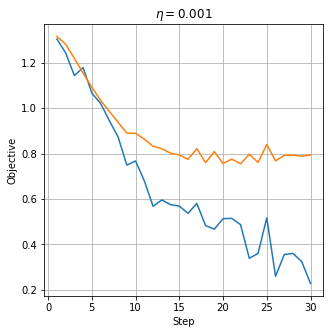

In [9]:
class CNN(torch.nn.Module):

    def __init__(self, in_features, out_features):   
        super(CNN, self).__init__()
        
        ## Defining the convolutional and fully connected layers with their parameters
        ## ===========================================================================
        self.bn0 = torch.nn.BatchNorm2d(1)
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=2)
        self.fc3 = torch.nn.Linear(in_features=80*80*64, out_features=256)
        self.fc4 = torch.nn.Linear(in_features=256, out_features=out_features)
    
    def forward(self, x):
        # import pdb; pdb.set_trace()
        x = torch.unsqueeze(x, 1)
        z = self.bn0(x)
        z = self.conv1(z)
        z = torch.nn.functional.relu(z)
        z = self.conv2(z)
        z = torch.nn.functional.relu(z)
        z = z.view(z.shape[0], -1)
        z = self.fc3(z)
        z = torch.nn.functional.relu(z)
        z = self.fc4(z)
        y = torch.nn.functional.log_softmax(z, dim=1)
        return y

## Test the train function
eta = 0.001
n_epochs = 30
model = CNN(in_features=1, out_features=4)
model = model.cuda()
train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                 torch.tensor(x_val).float(),
                                                 torch.tensor(y_val).long())

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective');

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

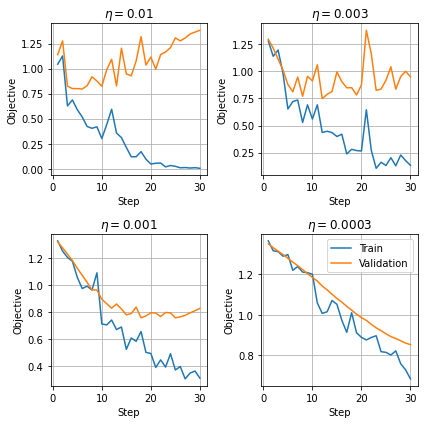

In [10]:
nn_epochs = 30
etas_list = (0.01, 3e-3, 1e-3, 3e-4)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i_eta, eta in enumerate(etas_list):
    model = CNN(in_features=1, out_features=4)
    model = model.cuda()
    train_objective_list, val_objective_list = train(model, eta, nn_epochs, train_loader,
                                                     torch.tensor(x_val).float(),
                                                     torch.tensor(y_val).long())
    
    ## Plot
    ax = axes.flat[i_eta]
    ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
    ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
    ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
    ax.set_xlabel('Step')
    ax.set_ylabel('Objective')
axes[1,1].legend()
fig.tight_layout()

Choosing $\eta=0.0003$

  0%|          | 0/200 [00:00<?, ?it/s]

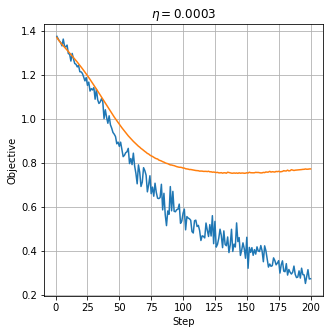

In [11]:
batch_size = 128
train_set = torch.utils.data.TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).long())
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
eta = 0.0003
n_epochs = 200
model = CNN(in_features=1, out_features=4)
model = model.cuda()
train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                  torch.tensor(x_val).float(),
                                                  torch.tensor(y_val).long())

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective');

143


  0%|          | 0/143 [00:00<?, ?it/s]

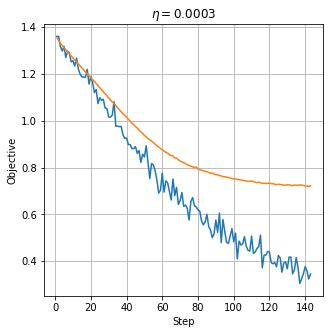

In [12]:
optimal_number_of_steps = np.argmin(val_objective_list)
print(optimal_number_of_steps)

eta = 0.0003
n_epochs = optimal_number_of_steps
model = CNN(in_features=1, out_features=4)
model = model.cuda()
train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                  torch.tensor(x_val).float(),
                                                  torch.tensor(y_val).long())

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective');

In [70]:
test_set = torch.utils.data.TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).long())
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size)
with torch.no_grad():
    test_score_list = []
    y_pred_list = []
    for x, y in test_loader:
        x = x.cuda()
        y = y.cuda()
        y_hat = model(x)
        test_score = (torch.argmax(y_hat, dim=1) != y).sum()

        y_pred_list.extend(torch.argmax(y_hat, dim=1))
        test_score_list.append(test_score.item())

y_pred = np.array([y_hat.cpu().numpy() for y_hat in y_pred_list])

test_score_cnn = np.sum(test_score_list) / len(test_set)
torch.save(model.state_dict(),  "./cnn_vox.pt")

print(f'CNN Model Test Score is: {test_score_cnn:.3}')

CNN Model Test Score is: 0.299


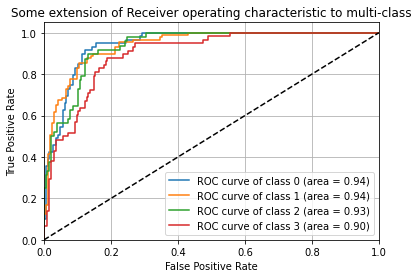

In [38]:
from sklearn import metrics

with torch.no_grad():
    score_list = []
    for x, y in test_loader:
        x = x.cuda()
        y = y.cuda()
        y_score = model(x)
        score_list.extend(y_score.cpu().numpy())

score_list = np.array(score_list)



# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test==i, score_list[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()

for i in range(4):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

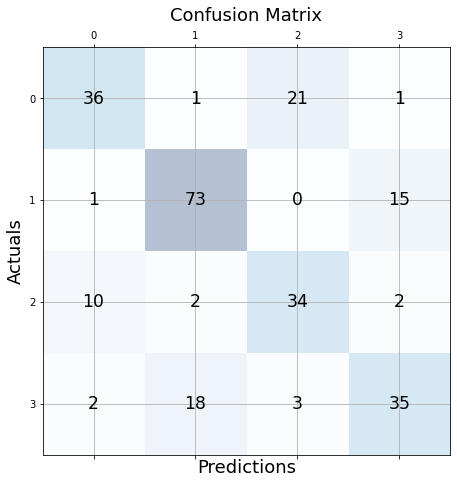

In [71]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()